In [1]:
import pandas as pd

def load_data(filepath):
    data = pd.read_csv(filepath, sep=",", header=None)
    data.columns = ["sepal_length", "sepal_width", 
                    "petal_length", "petal_width", 
                    "class"]
    return data

data = load_data("pset1/Iris_Data.txt")
print("{} data points loaded".format(len(data)))

150 data points loaded


# 1: Perceptron

## Plot Iris flower dataset

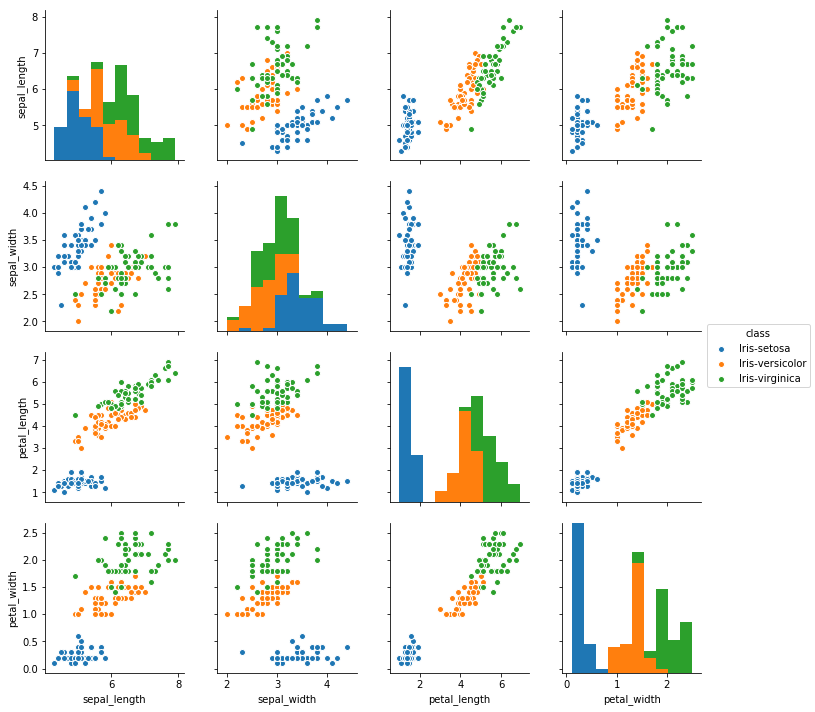

In [2]:
%matplotlib inline
import seaborn
seaborn.pairplot(data, hue='class')

## Perceptron

In [19]:
import numpy as np
import itertools


class Perceptron(object):
    def __init__(self, num_inputs):
        self.weights = np.random.rand(num_inputs)

    def __call__(self, feature_vector, log=False):
        # y = w * x
        y = sum(self.weights.T * feature_vector)
        if log:
            print("{} * {} = {}".format(self.weights, feature_vector, y))
        return y

    def step(self, feature_vector, target, learning_rate, log=False):
        assert target in [1, 2]
        y = self(feature_vector, log=log)
        predicted = self.convert_class(y)
        if predicted == target:  # yay
            return True
        if log:
            print("Predicted {}, but was {}".format(predicted, target))
        self.weights = self.weights + learning_rate * feature_vector * (-1 if y > 0 else +1)
        return False  # nay

    def convert_class(self, y, class1=1, class2=2):
        # y is a confidence value, convert to explicit class
        return class1 if y > 0 else class2

    def train_steps(self, features, targets, 
                    learning_rate=1e-1, num_epochs=10, 
                    yield_error_every=10, convert_targets=True, log=False):
        assert len(features) == len(targets)
        if convert_targets:
            targets = self._convert_targets(targets, log=log)
        errors = 0
        for step, feature_vector, target in zip(
                itertools.count(start=1), itertools.cycle(features), itertools.cycle(targets)):
            correct = self.step(feature_vector, target, learning_rate=learning_rate, log=log)
            errors = errors + (not correct)
            if step % yield_error_every == 0:
                yield step, errors / yield_error_every
                errors = 0
            if step / len(features) == num_epochs:
                break

    def _convert_targets(self, targets, log=False):
        mapping = {}
        result = []
        for target in targets:
            if target not in mapping:
                assert len(mapping) <= 1, "max of two classes allowed"
                mapping[target] = 1 + (max(mapping.values()) if len(mapping) > 0 else 0)
                if log:
                    print("Mapping {} to {}".format(target, mapping[target]))
            result.append(mapping[target])
        return result


In [4]:
features = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
classes = data['class']


def run_classes(class_names, num_epochs=10, learning_rate=1e-1, yield_error_every=25, log=False):
    index = classes.isin(class_names)
    print("Running {} vs {} ({} features)".format(*class_combination, sum(index)))
    _features, _classes = features[index].values, classes[index].values
    p = Perceptron(4)
    steps_errors = list(p.train_steps(_features, _classes,
                                      num_epochs=num_epochs, learning_rate=learning_rate,
                                      yield_error_every=yield_error_every, log=log))
    pyplot.figure()
    pyplot.plot([step for step, _ in steps_errors], [error for _, error in steps_errors])
    pyplot.title("{} vs {}".format(*class_combination))
    pyplot.xlabel("Steps")
    pyplot.ylabel("Classification error [%]")
    pyplot.ylim([-0.01, 0.1])


### Classification performance for pairwise combination of classes

Running Iris-setosa vs Iris-versicolor (100 features)
Running Iris-setosa vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)


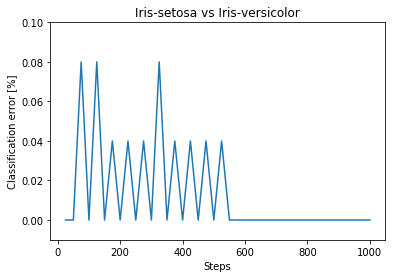

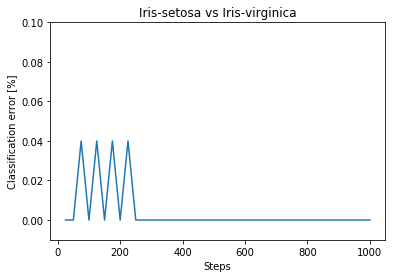

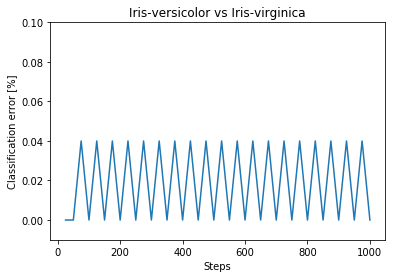

In [5]:
import itertools
from matplotlib import pyplot

for class_combination in itertools.combinations(np.unique(classes), 2):
    run_classes(class_combination)

setosa is linearly separable from the other two classes (perceptron converges).

versicolor and virginica are not linearly separable, the perceptron never converges

### Impact of learning rate

we only consider Iris-setosa vs Iris-versicolor.

Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)


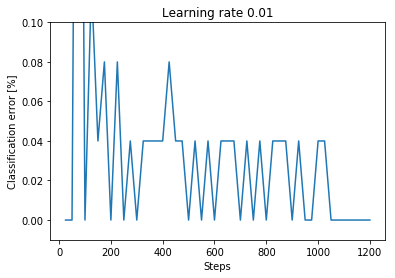

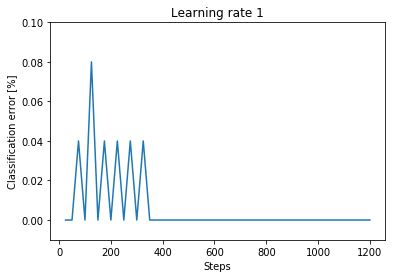

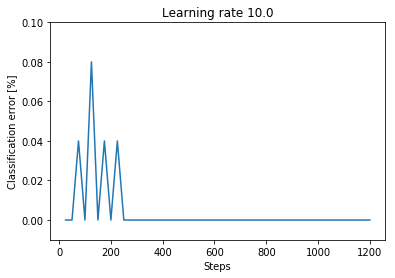

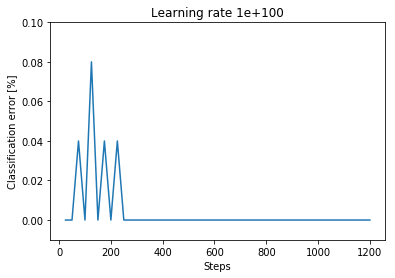

In [6]:
for learning_rate in [1e-2, 1, 1e1, 1e100]:
    run_classes(["Iris-setosa", "Iris-versicolor"], learning_rate=learning_rate, num_epochs=12)
    pyplot.title("Learning rate {}".format(learning_rate))

when the learning rate is too small, it takes a long time to converge because each update is just a tiny nudge in the right direction.

A large learning rate on the other hand leads to faster convergence at the possible price of missing the minima (this did not occur here, I guess we were lucky).

### Absolute correction procedure

# 7: Circle SOFM

# 2: Sanger's & Oja's rule

In [7]:
import itertools
import copy
import numpy as np


class Network(object):
    def __init__(self, num_inputs, num_outputs):
        self.weights = np.random.rand(num_inputs, num_outputs)

    def __call__(self, feature_vector):
        y = self.weights.T * feature_vector
        y = y.sum(axis=-1)
        # print("{} * {} -> {}".format(self.weights.shape, feature_vector.shape, y.shape))
        return y

    def step(self, feature_vector, learning_rate):
        y = self(feature_vector)
        for i in range(self.weights.shape[0]):
            for j in range(self.weights.shape[1]):
                weight_change = learning_rate * y[j] * (
                        feature_vector[i] - sum([self.weights[i, k] * y[k]
                                                 for k in range(self.weights.shape[1])]))
                self.weights[i, j] += weight_change
                assert not np.isnan(self.weights[i, j])

    def _weight_delta(self, prev_weights):
        diff = np.abs(self.weights - prev_weights)
        return np.sum(diff, axis=tuple(range(len(self.weights.shape))))

    def train_steps(self, features,
                    learning_rate=1e-1, max_epochs=10,
                    yield_delta_every=10):
        for step, feature_vector in enumerate(itertools.cycle(features)):
            prev_weights = copy.deepcopy(self.weights)
            self.step(feature_vector, learning_rate=learning_rate)
            if step % yield_delta_every == 0:
                weight_delta = self._weight_delta(prev_weights)
                yield step, weight_delta
                if weight_delta == 0:
                    print("converged")
                    break  # converged
            if step / len(features) == max_epochs:
                break


Text(0,0.5,'Weight delta')

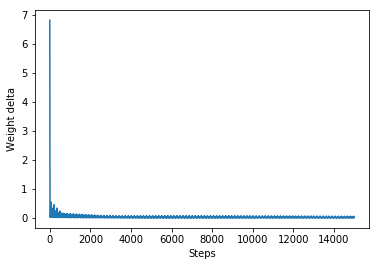

In [8]:
%matplotlib inline
from matplotlib import pyplot

features = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
net = Network(*[features.shape[-1]] * 2)
steps_deltas = list(net.train_steps(features, learning_rate=1e-2, max_epochs=100))
pyplot.plot([step for step, _ in steps_deltas], [delta for _, delta in steps_deltas])
pyplot.xlabel("Steps")
pyplot.ylabel("Weight delta")

[[ 0.09305649  0.46452485  0.02152096  0.85807084]
 [-0.13423479 -0.56759492  0.71266044  0.34547922]
 [-0.80002605  0.42850096  0.11644146 -0.05625457]
 [-0.56387316 -0.29973055 -0.18337027  0.05662477]]


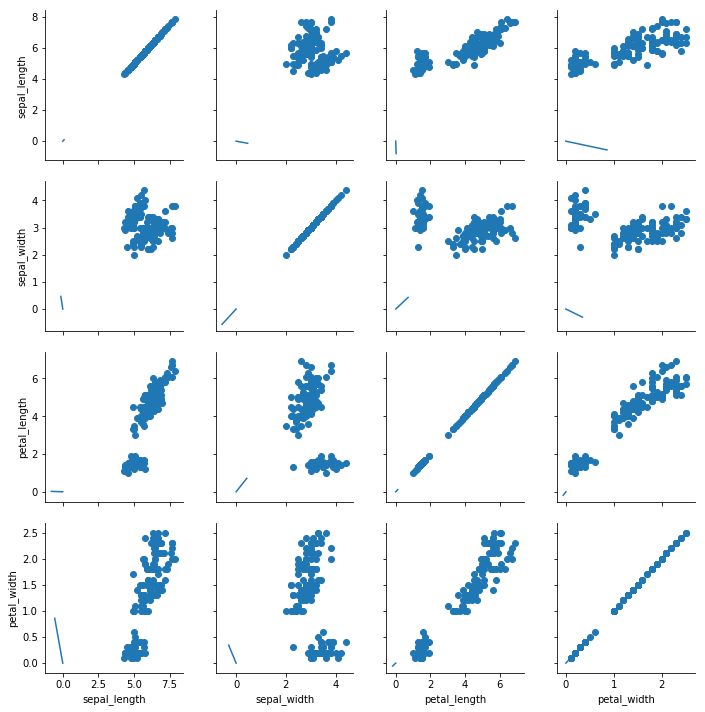

In [9]:
import seaborn
from matplotlib import pyplot
g = seaborn.PairGrid(data)
g.map(pyplot.scatter)
for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        g.axes[i][j].plot([0., net.weights[i, j]], [0., net.weights[j, i]])
print(net.weights)

# 4: Adaline

In [49]:
class Adaline(Perceptron):
    def step(self, feature_vector, target, learning_rate, log=False):
        assert target in [1, -1], "target {} out of range".format(target)
        y = self(feature_vector, log=log)
        self.weights += learning_rate * (target - y) * feature_vector
        
        predicted = self.convert_class(y, class1=1, class2=-1)
        if log:
            print("Predicted {}, was {} (y={})".format(
                predicted, target, y))
        if predicted == target:  # yay
            return True
        return False  # nay

100 data points


/home/martin/miniconda3/envs/9.S52-pset1/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/martin/miniconda3/envs/9.S52-pset1/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


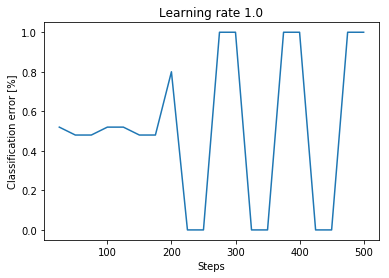

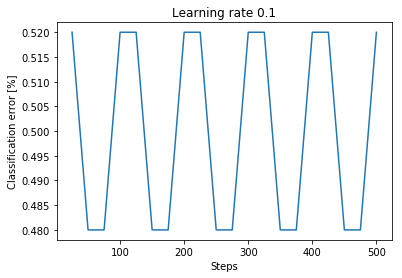

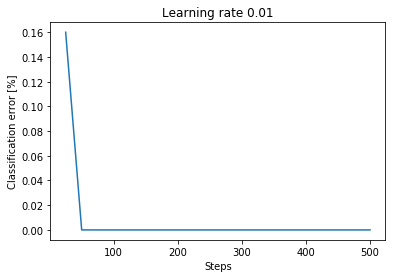

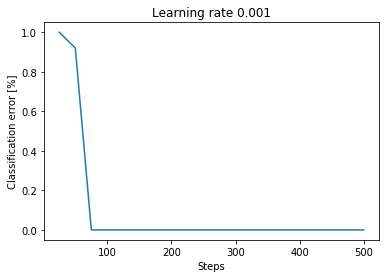

In [54]:
%matplotlib inline
from matplotlib import pyplot

data = load_data("pset1/Iris_Data.txt")
classes = ['Iris-versicolor', 'Iris-setosa']
data = data[data["class"].isin(classes)]
features = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
targets = [1 if c == classes[0] else -1 for c in data["class"].values]
print("{} data points".format(len(data)))

for learning_rate in [1e0, 1e-1, 1e-2, 1e-3]:
    model = Adaline(4)
    steps_errors = list(model.train_steps(features.values, targets,
                                          num_epochs=5, learning_rate=learning_rate,
                                          yield_error_every=25, convert_targets=False, log=False))
    pyplot.figure()
    pyplot.title("Learning rate {}".format(learning_rate))
    pyplot.plot([step for step, _ in steps_errors], [error for _, error in steps_errors])
    pyplot.xlabel("Steps")
    pyplot.ylabel("Classification error [%]")


If the learning rate is too large (in this case 0.1 or larger), learning does not converge.
That is because we overshoot the minima with our large step size and never actually land inside the minima.

With smaller learning rates (0.01 or lower in this case) on the other hand, we can approach the minima slower and thus actually land right inside it to converge.

# 5: SOFM Iris

# 6: SOFM unit square

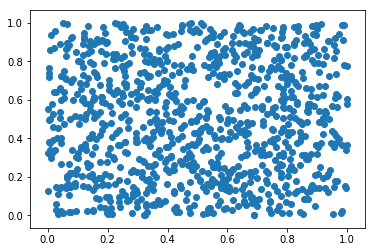

In [10]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

num_points = 1000
data = np.random.uniform(low=0, high=1, size=(num_points, 2))

pyplot.scatter(*data.T)

In [11]:
import numpy as np
import itertools

def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

class SOFM(object):
    def __init__(self, shape):
        assert len(shape) == 3  # 2D grid * num features
        self.grid_shape = shape[:-1]
        # re-arrange weights for easier access
        self.weights = np.random.rand(np.prod(self.grid_shape), shape[-1])
        self.neighborhood_radius = 0.5
        
    def lattice_location(self, i):
        return np.array(np.unravel_index(i, self.grid_shape))

    def neighborhood(self, i, j):
        ri, rj = self.lattice_location(i), self.lattice_location(j)
        lattice_distance = euclidean_distance(ri, rj)
        return np.exp(-np.power(lattice_distance, 2) /
                      2 * np.power(self.neighborhood_radius, 2))

    def __call__(self, feature_vector):
        best_matching_unit = np.argmin([euclidean_distance(
            feature_vector, self.weights[j]) for j in range(len(self.weights))])
        return best_matching_unit

    def step(self, feature_vector, learning_rate):
        bmu = self(feature_vector)
        for j in range(len(self.weights)):
            delta = learning_rate * self.neighborhood(j, bmu) \
                    * (feature_vector - self.weights[j])
            self.weights[j] += delta

    def train_steps(self, feature_vectors, learning_rate, num_epochs):
        for step, feature_vector in enumerate(itertools.cycle(feature_vectors)):
            self.step(feature_vector, learning_rate)
            if step / len(feature_vectors) == num_epochs:
                break

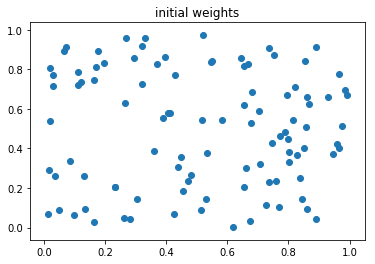

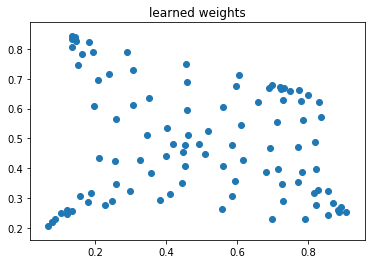

In [12]:
%matplotlib inline
from matplotlib import pyplot

s = SOFM(shape=(10, 10, 2))

pyplot.figure()
pyplot.title('initial weights')
pyplot.scatter(*s.weights.T)
# s.weights[np.ravel_multi_index([9, 9], s.grid_shape)] = (0., 0.75)

pyplot.figure()
pyplot.title('learned weights')
s.train_steps(data, learning_rate=1e0, num_epochs=10)
pyplot.scatter(*s.weights.T)

# 7: Circle SOFM

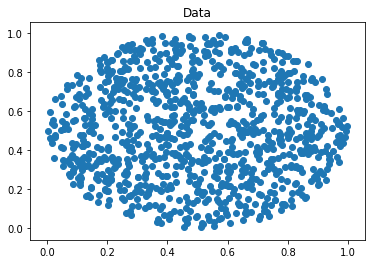

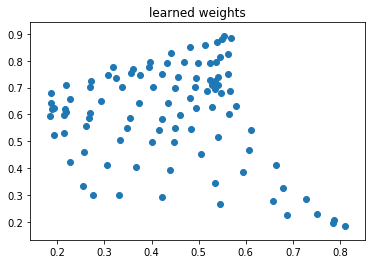

In [13]:
% matplotlib inline
from matplotlib import pyplot
import numpy as np

num_samples = 1000
phi = np.sqrt(np.random.rand(num_samples))
theta = np.random.uniform(low=0, high=2 * np.pi, size=num_samples)
data = np.array([0.5 * (phi * np.cos(theta) + 1), 
                 0.5 * (phi * np.sin(theta) + 1)]).T
pyplot.figure()
pyplot.title("Data")
pyplot.scatter(*data.T)

s = SOFM(shape=(10, 10, 2))
pyplot.figure()
pyplot.title('learned weights')
s.train_steps(data, learning_rate=1e0, num_epochs=10)
pyplot.scatter(*s.weights.T)
